Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](https://github.com/Project-MONAI/tutorials/blob/main/figures/spleen0.png?raw=1)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [10]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


2024-07-31 17:03:08.881636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:03:08.881705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:03:08.883192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup imports

In [11]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.dev2430
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9dd92b4a07706d4b80edace3d39fe008dc805d5a
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: 5.2.0
TorchVision version: 0.16.2
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.42.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [12]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# if directory is not None:
#     os.makedirs(directory, exist_ok=True)
# root_dir = tempfile.mkdtemp() if directory is None else directory
# print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [13]:
# import os
# from monai.apps.utils import download_and_extract

# root_dir = "/tmp/tmpzukybvx0"
# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar"
# compressed_file = "Task06_Lung.tar"
# md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

# # Ensure the root directory exists
# if not os.path.exists(root_dir):
#     os.makedirs(root_dir)

# # Remove the corrupted file if it exists
# corrupted_file_path = os.path.join(root_dir, compressed_file)
# if os.path.exists(corrupted_file_path):
#     os.remove(corrupted_file_path)

# # Attempt to download and extract the file again
# try:
#     download_and_extract(resource, compressed_file, root_dir, md5)
#     print("Download and extraction completed successfully.")
# except RuntimeError as e:
#     print(f"An error occurred: {e}")


In [14]:
# import tarfile
# import os

# def extract_tar_file(tar_file_path, extract_path):
#     """
#     Extracts the given .tar file to the specified directory.

#     :param tar_file_path: Path to the .tar file.
#     :param extract_path: Directory where the contents will be extracted.
#     """
#     if not os.path.exists(tar_file_path):
#         raise FileNotFoundError(f"The file {tar_file_path} does not exist.")

#     # Ensure the extract_path exists
#     if not os.path.exists(extract_path):
#         os.makedirs(extract_path)

#     # Open the .tar file
#     with tarfile.open(tar_file_path, 'r') as tar:
#         tar.extractall(path=extract_path)
#         print(f"Extracted {tar_file_path} to {extract_path}")

# # Example usage
# tar_file_path = '/kaggle/working/Task06_Lung.tar'  # Replace with the actual path to your .tar file
# extract_path = '/kaggle/working'  # Replace with the desired extraction directory

# extract_tar_file(tar_file_path, extract_path)


## Set MSD Spleen dataset path

In [24]:
data_dir = "/kaggle/input/lung-tumor-segment/data"
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [16]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [17]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([211, 160, 141]), label shape: torch.Size([211, 160, 141])


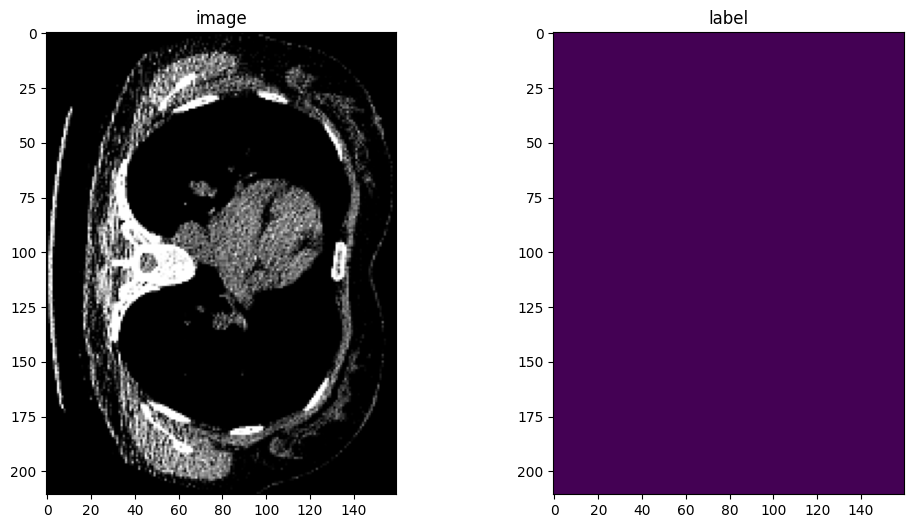

In [18]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [19]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

Loading dataset: 100%|██████████| 9/9 [00:54<00:00,  6.03s/it]


## Create Model, Loss, Optimizer

In [27]:
import torch
import torch.nn as nn
from monai.networks.nets import UNet

class ModifiedUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, pretrained_weights="/kaggle/input/spleen/spleen_ct_segmentation/models/model.pt"):
        super(ModifiedUNet, self).__init__()
        
        # Initialize the original UNet model
        self.network = UNet(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=2,  # Load weights for 2 classes
            channels=[16, 32, 64, 128, 256],
            strides=[2, 2, 2, 2],
            num_res_units=2,
            norm="batch"
        )
        
        # Modify the final layer to output a single channel
        self.network.out_conv = nn.Conv3d(
            in_channels=128,
            out_channels=out_channels,
            kernel_size=1
        )
        
        # Load pre-trained weights if provided
        if pretrained_weights:
            self.load_pretrained_weights(pretrained_weights)

    def load_pretrained_weights(self, path):
        state_dict = torch.load(path)
        # Update the state_dict for the changed output channels
        state_dict = {k: v for k, v in state_dict.items() if 'out_conv' not in k}
        self.network.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        return self.network(x)

# Example usage
pretrained_weights_path = '/kaggle/input/spleen/spleen_ct_segmentation/models/model.pt'
model = ModifiedUNet(in_channels=1, out_channels=1, pretrained_weights=pretrained_weights_path).to("cuda")

# Utilize DataParallel to use multiple GPUs
model = nn.DataParallel(model)

# Move the model to CUDA (GPU)
model = model.to("cuda")

print(torch.cuda.device_count())



2


In [ ]:

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
device = "cuda"
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("/kaggle/working/", "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/300
epoch 1 average loss: 0.4400
----------
epoch 2/300
epoch 2 average loss: 0.3790
saved new best metric model
current epoch: 2 current mean dice: 0.0448
best mean dice: 0.0448 at epoch: 2
----------
epoch 3/300
epoch 3 average loss: 0.3658
----------
epoch 4/300
epoch 4 average loss: 0.3455
saved new best metric model
current epoch: 4 current mean dice: 0.0961
best mean dice: 0.0961 at epoch: 4
----------
epoch 5/300
epoch 5 average loss: 0.3386
----------
epoch 6/300
epoch 6 average loss: 0.3249
current epoch: 6 current mean dice: 0.0484
best mean dice: 0.0961 at epoch: 4
----------
epoch 7/300
epoch 7 average loss: 0.3428
----------
epoch 8/300
epoch 8 average loss: 0.3207
saved new best metric model
current epoch: 8 current mean dice: 0.1182
best mean dice: 0.1182 at epoch: 8
----------
epoch 9/300
epoch 9 average loss: 0.3301
----------
epoch 10/300
epoch 10 average loss: 0.3281
current epoch: 10 current mean dice: 0.1057
best mean dice: 0.1182 at epoch: 8
---

In [ ]:
rm "/kaggle/working/Task06_Lung.tar"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class EnhancedUNet(nn.Module):
    def __init__(self):
        super(EnhancedUNet, self).__init__()
        self.model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm='batch',
            dropout=0.3  # Increase dropout rate
        )

    def forward(self, x):
        return self.model(x)

# Configuration
config = {
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "epochs": 300,
    "val_interval": 2,
    "learning_rate": 1e-4,
    "model_save_path": "./best_metric_model.pth",
    "roi_size": (160, 160, 160),
    "sw_batch_size": 4,
    "weight_decay": 1e-4,
    "scheduler_t0": 10,
    "scheduler_tmult": 2,
    "early_stopping_patience": 10
}

# Initialize the model
model = EnhancedUNet().to(config["device"])

# Loss function and optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config["scheduler_t0"], T_mult=config["scheduler_tmult"])
dice_metric = DiceMetric(include_background=False, reduction="mean")

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Training and Validation Loop
scaler = GradScaler()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
early_stopping_counter = 0

for epoch in range(config["epochs"]):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{config['epochs']}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(config["device"]), batch_data["label"].to(config["device"])
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % config["val_interval"] == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(config["device"]), val_data["label"].to(config["device"])
                val_outputs = sliding_window_inference(val_inputs, config["roi_size"], config["sw_batch_size"], model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), config["model_save_path"])
                print("Saved new best metric model")
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            print(f"Current epoch: {epoch + 1} Current mean dice: {metric:.4f}")
            print(f"Best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

        # Step the learning rate scheduler
        scheduler.step(epoch + early_stopping_counter / config["early_stopping_patience"])

    # Early stopping
    if early_stopping_counter >= config["early_stopping_patience"]:
        print("Early stopping triggered")
        break

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

# Plotting the loss and metric values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metric_values, label='Validation Dice Metric')
plt.xlabel('Epochs')
plt.ylabel('Dice Metric')
plt.title('Validation Dice Metric over Epochs')
plt.legend()

plt.show()


## Execute a typical PyTorch training process

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load("/content/best_metric_model.pth"))
model.eval()
device = "cuda"
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
import matplotlib.pyplot as plt
import torch
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, AsDiscrete
from monai.data import decollate_batch, DataLoader
from monai.metrics import DiceMetric

# Load the trained model
model.load_state_dict(torch.load("/kaggle/working//best_metric_model.pth"))
model.eval()

# Configuration
device = "cuda"
roi_size = (160, 160, 160)
sw_batch_size = 4
slice_idx = 80  # You can adjust this or iterate over different slices

# Function to plot images
def plot_images(img, label, pred, index):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Image {index}")
    plt.imshow(img, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Label {index}")
    plt.imshow(label)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Output {index}")
    plt.imshow(pred)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_inputs = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)

        # Perform inference
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

        # Get predictions
        pred = torch.argmax(val_outputs, dim=1).detach().cpu()
        img = val_inputs[0, 0, :, :, slice_idx].cpu()
        label = val_labels[0, 0, :, :, slice_idx].cpu()
        pred = pred[0, :, :, slice_idx]

        # Plot the images
        plot_images(img, label, pred, i)

        # Optionally break after a few iterations
        if i == 10:  # Adjust this number based on how many images you want to visualize
            break


In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=1)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load("/kaggle/working//best_metric_model.pth"))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 1
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Inference on Test Set

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=1)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [ ]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load("/content/best_metric_model.pth"))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 1
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)